# Endprojekt GIS Analyse - Location Analysis for a new Stadium in Graz

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Geospatial
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import osmnx as ox

# Raster processing
import os
import pyproj
# optinal code fix with PROJ_LIB if pyproj doesnt work properly
os.environ["PROJ_LIB"] = pyproj.datadir.get_data_dir()
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
from rasterio.features import shapes
from shapely.geometry import shape


Data Preparation
===============================================================================     

Getting district boundaries of Graz (District boundaries (Overpass Turbo (n.d.). Overpass API web interface. https://overpass-turbo.eu/ (Accessed December 2, 2025))) <br>
and <br>
population statistic (Stadt Graz (2025). Zahlen + Fakten: Bevölkerung, Bezirke, Wirtschaft, Geografie. https://www.graz.at/cms/beitrag/10034466/7772565/Zahlen_Fakten_Bevoelkerung_Bezirke_Wirtschaft.html (Accessed December 2, 2025))

In [2]:
#loading GeoJson Districts of Graz
gdf_districts = gpd.read_file("data/district_graz.geojson")
gdf_districts = gdf_districts[["name", "geometry"]].copy() #extract the columns needed

#loading csv with pop data of graz 
df_popgraz = pd.read_csv("data/Bevoelkerung Graz.csv", encoding="latin1", sep=";")

#merge the two datasets
gdf_districts_popGraz = gdf_districts.merge(df_popgraz, left_on="name", right_on="Bezirk")

Getting hard exklusion layers from OpenStreetMap via OSMnx, set the CRS to 32633 (UTM zone 33N) and buffer some of them:<br>
- water bodies buffer (10m)<br>
- parks/green areas <br>
- transport infrastructure <br>
- buildings (buffer 250m for hospitals, kingardens, cemeteries)

In [3]:
PLACE_NAME:str = "Graz, Austria"
#TARGET_CRS = "EPSG:32633"  # UTM zone 33N

In [4]:
tags_water = {
    "natural": ["water"],
    "waterway": ["river", "stream", "canal", "ditch"],
    "landuse": ["reservoir"],
    "water": ["lake", "river", "pond", "basin"]
}
gdf_water = ox.features_from_place(
    PLACE_NAME,
    tags=tags_water
)
gdf_water = gdf_water[["geometry"]].copy()
gdf_water["category"] = "water"

# Reproject
gdf_water = gdf_water.to_crs(epsg=32633)

# 20 meter buffer
gdf_water_Buffer20m = gdf_water.copy()
gdf_water_Buffer20m["geometry"] = gdf_water_Buffer20m.buffer(20)
gdf_water_Buffer20m.head()

geometry category
element  id                                                                 
relation 1306807  POLYGON ((532493.308 5213424.458, 532492.762 5...    water
         2325656  POLYGON ((536884.355 5207621.79, 536885.105 52...    water
         3403202  POLYGON ((536189.617 5210881.951, 536188.455 5...    water
         3562966  POLYGON ((533575.587 5209754.372, 533574.904 5...    water
         3587716  POLYGON ((535239.727 5206817.913, 535241.479 5...    water

In [5]:
#Excklusion Parks
tags_parks = {
    "leisure": [
        "park", "garden", "playground", "recreation_ground"
    ],
    "boundary": [
        "protected_area"
    ]
}
gdf_parks = ox.features_from_place(
    PLACE_NAME,
    tags=tags_parks
)

gdf_parks = gdf_parks[["geometry"]].copy()
gdf_parks["category"] = "green areas"

# Reproject
gdf_parks = gdf_parks.to_crs(epsg=32633)

# 20 meter buffer
gdf_parks_Buffer20m = gdf_parks.copy()
gdf_parks_Buffer20m["geometry"] = gdf_parks_Buffer20m.buffer(20)
gdf_parks_Buffer20m.head(5)

geometry  \
element id                                                              
node    859421763   POLYGON ((529258.583 5215245.914, 529258.487 5...   
        940994980   POLYGON ((532495.494 5215082.215, 532495.398 5...   
        1053837597  POLYGON ((534682.168 5213142.265, 534682.072 5...   
        1265834876  POLYGON ((532026.172 5209443.055, 532026.076 5...   
        1412653685  POLYGON ((532010.365 5216204.807, 532010.269 5...   

                       category  
element id                       
node    859421763   green areas  
        940994980   green areas  
        1053837597  green areas  
        1265834876  green areas  
        1412653685  green areas

In [6]:
#Exclusion Transport Areas
tags_transport = {
    "highway": [
        "motorway", "trunk", "primary", "secondary", "tertiary",
        "motorway_link", "trunk_link", "primary_link", "secondary_link"
    ],
    "railway": [
        "rail", "tram", "light_rail", "subway"
    ]
}

gdf_transport = ox.features_from_place(
    PLACE_NAME,
    tags=tags_transport
)

gdf_transport = gdf_transport[["geometry"]].copy()
gdf_transport["category"] = "transport infrastructure"

# Reproject
gdf_transport = gdf_transport.to_crs(epsg=32633)

# 20 meter buffer
gdf_transport_Buffer20m = gdf_transport.copy()
gdf_transport_Buffer20m["geometry"] = gdf_transport_Buffer20m.buffer(20)
gdf_transport_Buffer20m.head(20)

geometry  \
element id                                                           
way     3987860  POLYGON ((533449.684 5211136.395, 533465.333 5...   
        3991673  POLYGON ((533280.286 5213193.422, 533280.399 5...   
        3991674  POLYGON ((534340.711 5211868.999, 534341.198 5...   
        3992913  POLYGON ((533593.03 5212405.682, 533593 521240...   
        3992916  POLYGON ((536352.536 5209722.242, 536355.837 5...   
        3992920  POLYGON ((536223.209 5208898.865, 536215.025 5...   
        3992921  POLYGON ((537098.264 5209773.987, 537098.543 5...   
        3993614  POLYGON ((534692.734 5212269.011, 534695.215 5...   
        3993615  POLYGON ((535012.603 5212456.471, 535015.55 52...   
        3995445  POLYGON ((535250.201 5210298.075, 535251.198 5...   
        3997179  POLYGON ((533882.629 5212763.121, 533880.227 5...   
        3997181  POLYGON ((533526.762 5212817.099, 533526.869 5...   
        3997182  POLYGON ((533796.086 5212962.12, 533771.174 52...   
        3997183  POLYGON ((533059.821 5212644.213, 533060.055 5...   
        3997185  POLYGON ((532983.79 5212614.523, 532981.831 52...   
        3997187  POLYGON ((532404.634 5212619.653, 532402.702 5...   
        3997188  POLYGON ((530730.677 5209707.406, 530732.635 5...   
        3997189  POLYGON ((531384.022 5209762.696, 531382.568 5...   
        3997190  POLYGON ((533096.522 5208533.592, 533094.993 5...   
        3997191  POLYGON ((531379.256 5208939.667, 531380.633 5...   

                                 category  
element id                                 
way     3987860  transport infrastructure  
        3991673  transport infrastructure  
        3991674  transport infrastructure  
        3992913  transport infrastructure  
        3992916  transport infrastructure  
        3992920  transport infrastructure  
        3992921  transport infrastructure  
        3993614  transport infrastructure  
        3993615  transport infrastructure  
        3995445  transport infrastructure  
        3997179  transport infrastructure  
        3997181  transport infrastructure  
        3997182  transport infrastructure  
        3997183  transport infrastructure  
        3997185  transport infrastructure  
        3997187  transport infrastructure  
        3997188  transport infrastructure  
        3997189  transport infrastructure  
        3997190  transport infrastructure  
        3997191  transport infrastructure

In [7]:
#Exclusion Buildings
tags_buildings_hard = {
    "building": True
}

gdf_buildings = ox.features_from_place(
    PLACE_NAME,
    tags=tags_buildings_hard
)

gdf_buildings = gdf_buildings[["geometry"]].copy()
gdf_buildings["category"] = "buildings_hard"

# Reproject
gdf_buildings = gdf_buildings.to_crs(epsg=32633)
gdf_buildings_Buffer30m = gdf_buildings.copy()
gdf_buildings_Buffer30m["geometry"] = gdf_buildings_Buffer30m.buffer(30)
gdf_buildings_Buffer30m.head(5)

geometry  \
element id                                                              
node    278296607   POLYGON ((532743.99 5212987.937, 532743.846 52...   
        1083590320  POLYGON ((531854.409 5213308.019, 531854.264 5...   
        1188213884  POLYGON ((533232.322 5212779.72, 533232.177 52...   
        1446305820  POLYGON ((531810.911 5214585.035, 531810.767 5...   
        1485789259  POLYGON ((532044.902 5213725.416, 532044.757 5...   

                          category  
element id                          
node    278296607   buildings_hard  
        1083590320  buildings_hard  
        1188213884  buildings_hard  
        1446305820  buildings_hard  
        1485789259  buildings_hard

In [8]:
#Cemeteries with 250m Buffer
tags_cemetery = {
    "landuse": ["cemetery"],
    "amenity": ["grave_yard"]
}

gdf_cemetery = ox.features_from_place(
    PLACE_NAME,
    tags=tags_cemetery
)

gdf_cemetery = gdf_cemetery[["geometry"]].copy()
gdf_cemetery["category"] = "cemetery"

gdf_cemetery = gdf_cemetery.to_crs(epsg=32633)
gdf_cemetery.head(5)

geometry  \
element  id                                                              
node     1447016305                      POINT (535889.182 5209509.97)   
relation 1252339     POLYGON ((531967.661 5210631.508, 531988.86 52...   
         1252342     POLYGON ((532066.233 5210275.077, 532053.994 5...   
         2694625     MULTIPOLYGON (((531233.48 5218089.831, 531255....   
         17946151    POLYGON ((534965.319 5212317.125, 534995.58 52...   

                     category  
element  id                    
node     1447016305  cemetery  
relation 1252339     cemetery  
         1252342     cemetery  
         2694625     cemetery  
         17946151    cemetery

Merge to one geodataframe and dissolve to one geometry

In [9]:
gdf_exclusion_areas = pd.concat([
    gdf_water_Buffer20m,
    gdf_parks_Buffer20m,
    gdf_transport_Buffer20m,
    gdf_buildings_Buffer30m,
    gdf_cemetery,
], ignore_index=True)

In [10]:
gdf_exclusion_areas.head(5)

,geometry,category
0,"POLYGON ((532493.308 5213424.458, 532492.762 5...",water
1,"POLYGON ((536884.355 5207621.79, 536885.105 52...",water
2,"POLYGON ((536189.617 5210881.951, 536188.455 5...",water
3,"POLYGON ((533575.587 5209754.372, 533574.904 5...",water
4,"POLYGON ((535239.727 5206817.913, 535241.479 5...",water


In [11]:
gdf_exclusion_areas.geometry.geom_type.value_counts()


Polygon         70637
MultiPolygon        7
Point               1
Name: count, dtype: int64

In [12]:
gdf_exclusion_areas = gdf_exclusion_areas[
    gdf_exclusion_areas.geometry.geom_type != "Point"
]
gdf_exclusion_areas = gdf_exclusion_areas.explode(
    ignore_index=True
)
gdf_exclusion_areas.geometry.geom_type.value_counts()

Polygon    70664
Name: count, dtype: int64

Reprojecting DEM from WGS84 to UTM33N and calculate slope 

In [13]:
dem_in = "data/DEM30_Graz.tif"          # original DEM
dem_utm = "data/DEM30_Graz_utm33.tif"   # output DEM (UTM33N)

with rasterio.open(dem_in) as src:
    src_crs = src.crs if src.crs is not None else CRS.from_epsg(4326)
    dst_crs = CRS.from_epsg(32633)  # UTM Zone 33N

    transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src.width, src.height, *src.bounds
    )

    profile = src.profile.copy()
    profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "nodata": src.nodata if src.nodata is not None else -9999
    })

    with rasterio.open(dem_utm, "w", **profile) as dst:
        dst_array = np.full((height, width), profile["nodata"], dtype=profile["dtype"])
        dst.write(dst_array, 1)

        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
            src_nodata=src.nodata,
            dst_nodata=profile["nodata"]
        )

In [14]:
dem_path = "data/DEM30_Graz_utm33.tif"
slope_path = "data/dem_slope.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1, masked=True).astype("float64")
    profile = src.profile.copy()
    transform = src.transform

xres = transform.a
yres = abs(transform.e)

dzdy, dzdx = np.gradient(dem.filled(np.nan), yres, xres)

slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

nodata_out = -9999.0
slope_out = np.where(np.isnan(slope_deg), nodata_out, slope_deg).astype(np.float32)

profile.update(dtype=rasterio.float32, count=1, nodata=nodata_out)

with rasterio.open(slope_path, "w", **profile) as dst:
    dst.write(slope_out, 1)


Polygonize slope raster for areas with slope greater than threshold (e.g. 5 degrees)

In [15]:
slope_path = "data/dem_slope.tif"
out_path   = "data/slope_filtered.shp"

threshold   = 5.0     # Grad
min_area_m2 = 500.0   # Mindestfläche

with rasterio.open(slope_path) as src:
    slope = src.read(1)
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

mask = slope > threshold
if nodata is not None:
    mask = mask & (slope != nodata)
mask = mask & np.isfinite(slope)

value_raster = mask.astype(np.uint8)

geoms = []
for geom, value in shapes(value_raster, mask=mask, transform=transform):
    if value == 1:
        geoms.append(shape(geom))

gdf_slope = gpd.GeoDataFrame(geometry=geoms, crs=crs)

gdf_slope["diss"] = 1
gdf_slope = gdf_slope.dissolve(by="diss")
gdf_slope = gdf_slope.explode(index_parts=False).reset_index(drop=True)

gdf_slope["area_m2"] = gdf_slope.area
gdf_slope = gdf_slope[gdf_slope["area_m2"] >= min_area_m2]

gdf_slope["slope_gt"] = threshold
gdf_slope = gdf_slope[["slope_gt", "area_m2", "geometry"]]
gdf_slope.to_file(out_path, driver="ESRI Shapefile")

print(f"{len(gdf_slope)} Polygone gespeichert in {out_path}")

4307 Polygone gespeichert in data/slope_filtered.shp


In [16]:
graz = gdf_districts_popGraz.copy()
steep = gpd.read_file("data/slope_filtered.shp")

if graz.crs != steep.crs:
    graz = graz.to_crs(steep.crs)

#fix potential geometry issues
graz["geometry"] = graz.geometry.buffer(0)
steep["geometry"] = steep.geometry.buffer(0)

#union all areas 
steep_union = steep.geometry.union_all()

#differnce
result = graz.copy()
result["geometry"] = result.geometry.difference(steep_union)

#remove empty geometries
result = result[result.geometry.notna() & ~result.is_empty]

result.to_file("data/graz_suitable_slope.shp", driver="ESRI Shapefile")



/var/folders/wl/57rw449x3pn6q6_9zftwy8f40000gn/T/ipykernel_11496/4066166847.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result.to_file("data/graz_suitable_slope.shp", driver="ESRI Shapefile")
/Users/max/Documents/Studium/Geo_Master/Wintersemester_25/3_GIS_AT_2/venv_gat2_1011/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Größe in km2' to 'Größe in'
  ogr_write(
/Users/max/Documents/Studium/Geo_Master/Wintersemester_25/3_GIS_AT_2/venv_gat2_1011/lib/python3.10/site-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'Einwohner pro km2' to 'Einwohne_1'
  ogr_write(


In [26]:
import geopandas as gpd

suitable = gpd.read_file("data/graz_suitable_slope.shp")
excluded = gdf_exclusion_areas.copy()

if suitable.crs != excluded.crs:
    excluded = excluded.to_crs(suitable.crs)

suitable["geometry"] = suitable.geometry.buffer(0)
excluded["geometry"] = excluded.geometry.buffer(0)

excluded_union = excluded.geometry.union_all()

suitable_area = suitable.copy()
suitable_area["geometry"] = suitable_area.geometry.difference(excluded_union)

suitable_area = suitable_area[suitable_area.geometry.notna() & ~suitable_area.is_empty].copy()

suitable_area = suitable_area.explode(index_parts=False).reset_index(drop=True)
suitable_area = suitable_area[suitable_area.geometry.notna() & ~suitable_area.is_empty].copy()

suitable_area["area_m2"] = suitable_area.area
suitable_area = suitable_area[suitable_area["area_m2"] >= 130000][["area_m2", "geometry"]]

suitable_area.to_file("data/graz_final_suitable_areas_slope.shp", driver="ESRI Shapefile")
print("ready:", len(suitable_area), "Polygons")

ready: 5 Polygons


/var/folders/wl/57rw449x3pn6q6_9zftwy8f40000gn/T/ipykernel_11496/1892264636.py:17: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  suitable_area = suitable_area[suitable_area.geometry.notna() & ~suitable_area.is_empty].copy()


In [18]:
print("Graz CRS:", graz.crs)
print("Steep CRS:", steep.crs)
slope_graz = gpd.read_file("data/graz_suitable_slope.shp")
print("Slope CRS:", slope_graz.crs)

Graz CRS: EPSG:32633
Steep CRS: EPSG:32633
Slope CRS: EPSG:32633


# Weighting and Scoring

medium weight criteria when not near by kindergarten, hospital, cemetery and churches <br>
high weight criteria when near by transport infrastructure <br>

In [19]:
#filter kindergartens
tags_kindergarten = {
    "amenity": ["kindergarten"]
}

gdf_kindergarten = ox.features_from_place(
    PLACE_NAME,
    tags=tags_kindergarten
)

gdf_kindergarten = gdf_kindergarten[["geometry"]].copy()
gdf_kindergarten["category"] = "kindergarten"

gdf_kindergarten = gdf_kindergarten.to_crs(epsg=32633)
gdf_kindergarten.head(5)


geometry      category
element id                                                      
node    270508839   POINT (530445.941 5213616.972)  kindergarten
        629028254    POINT (535001.653 5212012.05)  kindergarten
        629029213   POINT (535437.684 5215756.501)  kindergarten
        855502493    POINT (532981.04 5214572.576)  kindergarten
        1244386379   POINT (531537.76 5214648.173)  kindergarten

In [20]:
#filter hospitals
tags_hospital = {
    "amenity": ["hospital"]
}

gdf_hospital = ox.features_from_place(
    PLACE_NAME,
    tags=tags_hospital
)

gdf_hospital = gdf_hospital[["geometry"]].copy()
gdf_hospital["category"] = "hospital"

gdf_hospital = gdf_hospital.to_crs(epsg=32633)
gdf_hospital.head(5)

geometry  \
element id                                                              
node    2238807934                      POINT (530040.636 5211023.45)   
way     4236777     POLYGON ((535590.696 5215182.609, 535589.492 5...   
        83810712    POLYGON ((530371.341 5214034.341, 530367.276 5...   
        83813652    POLYGON ((531765.665 5209187.656, 531790.914 5...   
        84202665    POLYGON ((530371.341 5214034.341, 530317.416 5...   

                    category  
element id                    
node    2238807934  hospital  
way     4236777     hospital  
        83810712    hospital  
        83813652    hospital  
        84202665    hospital

In [25]:
#filter religious sites

tags_religious = {
    "amenity": ["place_of_worship"]
}

gdf_religious = ox.features_from_place(
    PLACE_NAME,
    tags=tags_religious
)

# Keep geometry and religion column if present
cols = ["geometry"]
if "religion" in gdf_religious.columns:
    cols.append("religion")
gdf_religious = gdf_religious[cols].copy()
gdf_religious["category"] = "religious_site"

# Reproject to UTM zone 33N
gdf_religious = gdf_religious.to_crs(epsg=32633)
gdf_religious.head(10)

geometry   religion        category
element id                                                                   
node    257412068   POINT (532209.085 5212488.002)  christian  religious_site
        260033619   POINT (532394.556 5211530.942)  christian  religious_site
        278296607    POINT (532713.99 5212987.937)  christian  religious_site
        338791881    POINT (531690.39 5215600.434)  christian  religious_site
        902539964   POINT (530071.396 5214134.077)  christian  religious_site
        964874241   POINT (532913.145 5211213.345)     muslim  religious_site
        1001084358  POINT (533168.956 5213087.388)  christian  religious_site
        1374681290  POINT (532521.407 5215988.309)  christian  religious_site
        1474984039  POINT (535505.707 5214401.055)     muslim  religious_site
        1503693723   POINT (537522.619 5213063.58)  christian  religious_site

In [23]:
#filter cemeteries 
tags_cemetery = {
    "landuse": ["cemetery"],
    "amenity": ["grave_yard", "cemetery"]
}


gdf_cemetery = ox.features_from_place(
    PLACE_NAME,
    tags=tags_cemetery
)

gdf_cemetery = gdf_cemetery[["geometry"]].copy()
gdf_cemetery["category"] = "cemetery"

gdf_cemetery = gdf_cemetery.to_crs(epsg=32633)
gdf_cemetery.head(5)

geometry  \
element  id                                                              
node     1447016305                      POINT (535889.182 5209509.97)   
relation 1252339     POLYGON ((531967.661 5210631.508, 531988.86 52...   
         1252342     POLYGON ((532066.233 5210275.077, 532053.994 5...   
         2694625     MULTIPOLYGON (((531233.48 5218089.831, 531255....   
         17946151    POLYGON ((534965.319 5212317.125, 534995.58 52...   

                     category  
element  id                    
node     1447016305  cemetery  
relation 1252339     cemetery  
         1252342     cemetery  
         2694625     cemetery  
         17946151    cemetery

# 4. Analysis

Distance to Hospitals, Kindergartens, Cemeteries, Religious Sites statt nur Kirchen

In [27]:
from shapely.geometry import Point

# Use centroids for polygons as representative points
suitable_area["centroid"] = suitable_area.geometry.centroid

# Function to calculate minimum distance from each centroid to a set of features
def min_distance(centroids, features):
    return centroids.apply(lambda pt: features.distance(pt).min())

# Calculate distances
suitable_area["dist_hospital"] = min_distance(suitable_area["centroid"], gdf_hospital.geometry)
suitable_area["dist_kindergarten"] = min_distance(suitable_area["centroid"], gdf_kindergarten.geometry)
suitable_area["dist_cemetery"] = min_distance(suitable_area["centroid"], gdf_cemetery.geometry)
suitable_area["dist_religious"] = min_distance(suitable_area["centroid"], gdf_religious.geometry)

Scoring/Weighting Based on Distances: Assign scores to each site based on proximity to sensitive sites (further = better)

In [ ]:
# linear scoring, further than 500m = best (score 1), closer than 100m = worst (score 0)
def score_distance(dist, min_dist=100, max_dist=500):
    return ((dist - min_dist) / (max_dist - min_dist)).clip(0, 1)

suitable_area["score_hospital"] = score_distance(suitable_area["dist_hospital"])
suitable_area["score_kindergarten"] = score_distance(suitable_area["dist_kindergarten"])
suitable_area["score_cemetery"] = score_distance(suitable_area["dist_cemetery"])
suitable_area["score_religious"] = score_distance(suitable_area["dist_religious"])

Convert Final Polygons to Points: centroids for point-based network analysis.

In [29]:
suitable_points = suitable_area.copy()
suitable_points["geometry"] = suitable_points["centroid"]

Download and Prepare OSM Networks drive and walk

In [30]:
import osmnx as ox
import networkx as nx

# Drivable network (for car accessibility)
G_drive = ox.graph_from_place(PLACE_NAME, network_type="drive")
G_drive = ox.project_graph(G_drive, to_crs="EPSG:32633")

# Walkable network (for pedestrian/public transport access)
G_walk = ox.graph_from_place(PLACE_NAME, network_type="walk")
G_walk = ox.project_graph(G_walk, to_crs="EPSG:32633")

Assign Nearest Network Nodes to Each Candidate Site

In [31]:
# For car access
suitable_area["nearest_drive_node"] = suitable_area["centroid"].apply(lambda pt: ox.nearest_nodes(G_drive, pt.x, pt.y))

# For pedestrian/public transport access
suitable_area["nearest_walk_node"] = suitable_area["centroid"].apply(lambda pt: ox.nearest_nodes(G_walk, pt.x, pt.y))

Car Accessibility: Distance to Nearest Highway Exit

In [33]:
# Get all highway exits in Graz
tags_exit = {"highway": ["motorway_junction"]}
gdf_exits = ox.features_from_place(PLACE_NAME, tags=tags_exit)
gdf_exits = gdf_exits.to_crs(epsg=32633)
exit_nodes_drive = gdf_exits.geometry.apply(lambda pt: ox.nearest_nodes(G_drive, pt.x, pt.y))

def min_route_length(node, exit_nodes, G):
    lengths = []
    for exit_node in exit_nodes:
        try:
            length = nx.shortest_path_length(G, node, exit_node, weight="length")
            lengths.append(length)
        except nx.NetworkXNoPath:
            continue
    return min(lengths) if lengths else None
suitable_area["car_accessibility"] = suitable_area["nearest_drive_node"].apply(lambda n: min_route_length(n, exit_nodes_drive, G_drive))

Public transport stops in Graz

In [39]:
# Public transport stops in Graz
tags_stops = {
    "highway": ["bus_stop"],
    "public_transport": ["platform", "stop_position"],
    "railway": ["tram_stop"]
}

gdf_stops = ox.features_from_place(
    PLACE_NAME,
    tags=tags_stops
)

# Keep only Point geometries (for nearest_nodes)
gdf_stops = gdf_stops[gdf_stops.geometry.geom_type == "Point"].copy()
gdf_stops["category"] = "public_transport_stop"

# Find nearest walkable network node for each stop
stop_nodes_walk = gdf_stops.geometry.apply(lambda pt: ox.nearest_nodes(G_walk, pt.x, pt.y))

# Improved min_route_length with error handling
def min_route_length(node, target_nodes, G):
    lengths = []
    for target in target_nodes:
        try:
            length = nx.shortest_path_length(G, node, target, weight="length")
            lengths.append(length)
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            continue
    return min(lengths) if lengths else None

In [41]:


# Calculate walk accessibility for each candidate site
#suitable_area["walk_accessibility"] = suitable_area["nearest_walk_node"].apply(
#    lambda n: min_route_length(n, stop_nodes_walk, G_walk)
#)

In [40]:
# For all candidate nodes, compute shortest path to any stop node in one go
from networkx import multi_source_dijkstra_path_length

# Get all unique stop nodes as a set
stop_nodes_set = set(stop_nodes_walk)

# Compute shortest path lengths from all stop nodes to all nodes in the graph
lengths = multi_source_dijkstra_path_length(G_walk, stop_nodes_set, weight="length")

# Map each candidate's nearest_walk_node to its shortest path to any stop
def get_walk_accessibility(node):
    return lengths.get(node, None)

suitable_area["walk_accessibility"] = suitable_area["nearest_walk_node"].apply(get_walk_accessibility)

Distance to Residential Areas

In [42]:
# Download residential landuse polygons
tags_residential = {"landuse": ["residential"]}
gdf_residential = ox.features_from_place(PLACE_NAME, tags=tags_residential)
gdf_residential = gdf_residential.to_crs(epsg=32633)

# Calculate minimum distance from each centroid to residential areas
suitable_area["dist_residential"] = suitable_area["centroid"].apply(lambda pt: gdf_residential.distance(pt).min())

Population-Density-Weighted Area

In [45]:
from shapely.geometry import Point

# Calculate area (in m²) for each district
gdf_districts["area_m2"] = gdf_districts.geometry.area

# Load population data
df_popgraz = pd.read_csv("data/Bevoelkerung Graz.csv", encoding="latin1", sep=";")

# Merge using the correct column names
gdf_districts_popGraz = gdf_districts.merge(df_popgraz, left_on="name", right_on="Bezirk")

# Use the existing population density column (convert km² to m² for weighting)
gdf_districts_popGraz["pop_density_m2"] = gdf_districts_popGraz["Einwohner pro km2"] / 1e6

# Calculate centroids for each district
gdf_districts_popGraz["centroid"] = gdf_districts_popGraz.geometry.centroid

# Geometric center of Graz (simple centroid of all districts)
city_center = gdf_districts.unary_union.centroid
suitable_area["dist_center"] = suitable_area["centroid"].distance(city_center)

# Population-density-weighted center
total_weight = gdf_districts_popGraz["pop_density_m2"].sum()
weighted_x = (gdf_districts_popGraz["centroid"].x * gdf_districts_popGraz["pop_density_m2"]).sum() / total_weight
weighted_y = (gdf_districts_popGraz["centroid"].y * gdf_districts_popGraz["pop_density_m2"]).sum() / total_weight
pop_density_center = Point(weighted_x, weighted_y)
suitable_area["dist_pop_density_center"] = suitable_area["centroid"].distance(pop_density_center)

/var/folders/wl/57rw449x3pn6q6_9zftwy8f40000gn/T/ipykernel_11496/1292640442.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_districts["area_m2"] = gdf_districts.geometry.area
/var/folders/wl/57rw449x3pn6q6_9zftwy8f40000gn/T/ipykernel_11496/1292640442.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_districts_popGraz["centroid"] = gdf_districts_popGraz.geometry.centroid
/var/folders/wl/57rw449x3pn6q6_9zftwy8f40000gn/T/ipykernel_11496/1292640442.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_center = gdf_districts.unary_union.centroid



Normalize and combine all relevant scores

In [ ]:
# Normalize distances (further is better, 0 = worst, 1 = best)
def score_distance(dist, min_dist=100, max_dist=500):
    return ((dist - min_dist) / (max_dist - min_dist)).clip(0, 1)

suitable_area["score_hospital"] = score_distance(suitable_area["dist_hospital"])
suitable_area["score_kindergarten"] = score_distance(suitable_area["dist_kindergarten"])
suitable_area["score_cemetery"] = score_distance(suitable_area["dist_cemetery"])
suitable_area["score_religious"] = score_distance(suitable_area["dist_religious"])
suitable_area["score_residential"] = score_distance(suitable_area["dist_residential"])
suitable_area["score_center"] = 1 - score_distance(suitable_area["dist_center"], min_dist=0, max_dist=5000)  # closer to center is better
suitable_area["score_pop_center"] = 1 - score_distance(suitable_area["dist_pop_density_center"], min_dist=0, max_dist=5000)
suitable_area["score_car_access"] = 1 - score_distance(suitable_area["car_accessibility"], min_dist=0, max_dist=5000)
suitable_area["score_walk_access"] = 1 - score_distance(suitable_area["walk_accessibility"], min_dist=0, max_dist=2000)

Combine Scores and Rank Sites

In [ ]:
# simple average 
score_columns = [
    "score_hospital", "score_kindergarten", "score_cemetery", "score_religious",
    "score_residential", "score_center", "score_pop_center",
    "score_car_access", "score_walk_access"
]
suitable_area["final_score"] = suitable_area[score_columns].mean(axis=1)
suitable_area = suitable_area.sort_values("final_score", ascending=False)
print(suitable_area)

            area_m2                                           geometry  \
2947  144740.794461  POLYGON ((529224.949 5209878.792, 529230.07 52...   
70    285601.454140  POLYGON ((536568.567 5208443.084, 536568.567 5...   
94    223975.850598  POLYGON ((533812.116 5209817.051, 533812.434 5...   
3190  143755.733017  POLYGON ((532150.514 5207300.07, 532097.825 52...   
3169  136144.521081  POLYGON ((534081.212 5208940.555, 534081.212 5...   

                            centroid  dist_hospital  dist_kindergarten  \
2947  POINT (529468.717 5209952.445)    1214.143064        1143.428084   
70    POINT (536166.054 5208508.227)    4038.057289         946.303078   
94     POINT (534139.64 5209755.411)    2027.081477         519.019636   
3190  POINT (531961.593 5207404.717)    1676.760883         555.936511   
3169  POINT (533952.779 5208682.984)    1833.020863         267.403807   

      dist_cemetery  dist_religious  score_hospital  score_kindergarten  \
2947    1645.830670      544.819088

# Visualization of locations

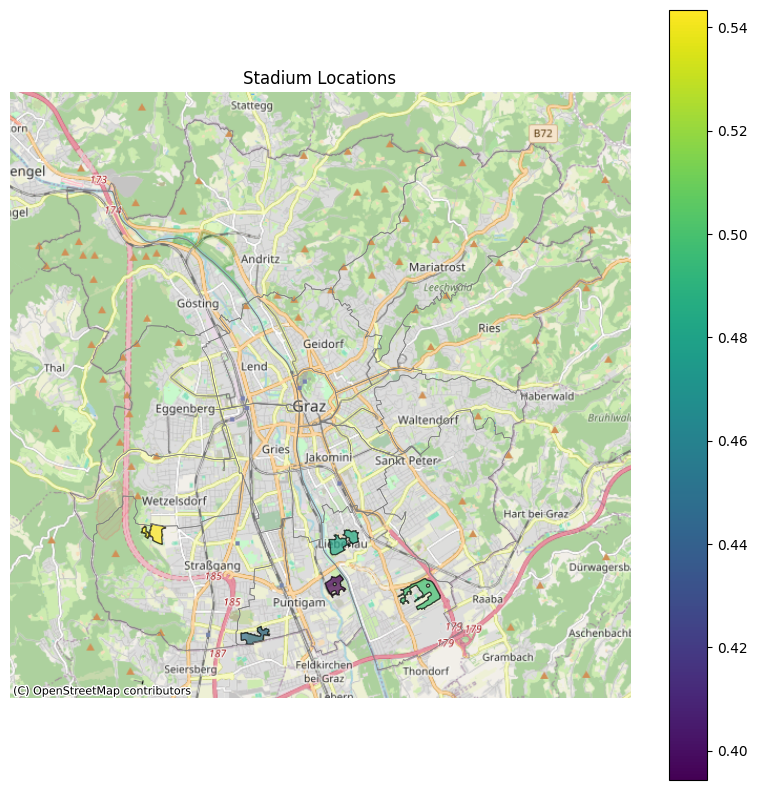

In [54]:
# Plot top 5 candidate sites 
import contextily as ctx

top5 = suitable_area.head(5).copy()
top5 = top5.to_crs(epsg=3857)
gdf_districts_web = gdf_districts.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_districts_web.boundary.plot(ax=ax, color="gray", linewidth=0.5)
top5.plot(ax=ax, column="final_score", cmap="viridis", legend=True, edgecolor="black", alpha=0.7)

# Annotate rank
for idx, row in top5.iterrows():
    ax.annotate(f"{idx+1}", xy=(row["centroid"].x, row["centroid"].y), color="white", weight="bold", fontsize=12, ha="center", va="center")

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Stadium Locations")
plt.axis("off")
plt.show()